# Reset Put Option

A reset put option is similar to a standard put option except that the exercise price is reset equal to the stock price on the pre-specified reset date if this stock price exceeds the original exercise price. Unlike the standard put option, a Reset put option has a stochastic strike price. On issue date, the reset put option has a strike price equal to the stock price. However, if the stock price exceeds the original strike price on a pre-specified future reset date, then the strike price is reset to the current strike price.

This notebook proposes three approaches to pricing the exotic option: the binomial tree approach, Monte Carlo simulation approach, and the closed form solution. The presentation accompanying this notebook can be found in my [website](https://www.brianlim.xyz/files/Reset%20Put%20Option.pdf).

To read more about Reset Put Option, you can refer to the paper by [Gray and Whaley, 1999](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.1015.8221&rep=rep1&type=pdf).

## Load Libraries

First, we import the necessary libraries

In [1]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm
import matplotlib.pyplot as plt

## Binomial Tree

For the binomial tree implementation, instead of doing the naive approach of doing path dependent options, we can optimize our calculations since we are only concerned with the value at $T_1$. The formula used is from [Shparber and Resheff, 2004](https://www.researchgate.net/publication/240390357_Valuation_of_Cliquet_Options).

$$p_0 = e^{-rT_2} \sum_{j=0}^{n_1}\sum_{i=j}^{n_2-n_1+j} \frac{n_1! (n_2 - n_1)!}{j! (n_1 - j)! (i - j)! (n_2 - n_1 - i + j)!} p^i (1-p)^{n_2-i} \max(S_0 - S_0 u^{i}d^{n_2-i}, S_0 u^{j}d^{n_1-j} - S_0 u^i d^{n_2-i}, 0)$$

To further optimize the performance of this implementation, we can use the recursive form of the combination function and apply dynamic programming.

$${n \choose r} = {{n-1} \choose {r}} + {{n-1} \choose {r-1}}$$

In [1]:
memo = [[-1 for _ in range(1000)] for _ in range(1000)]

def choose(n,r):
    if r > n or r < 0:
        return 0
    elif n == 1:
        return 1
    elif memo[n][r] == -1:
        memo[n][r] = choose(n-1, r-1) + choose(n-1, r)
    return memo[n][r]
    
def BT_option_price(S0, T2, n1, n2, r, q, sigma):
    dt = T2 / n2
    u = np.exp(  sigma * np.sqrt(dt))
    d = np.exp(- sigma * np.sqrt(dt))
    pu = (np.exp( (r - q) * dt) - d) / (u - d)
    pd = (u - np.exp( (r - q) * dt)) / (u - d)

    ans = 0
    for j in range(n1+1):
        for i in range(j, n2 - n1 + j + 1):
            ans += (
                choose(n1, j) * choose (n2 - n1, i - j) * pow(pu, i) * pow(pd, n2 - i) *
                max(
                    S0 - S0 * pow(u, i) * pow(d, n2 - i),
                    S0 * pow(u, j) * pow(d, n1 - j) - S0 * pow(u, i) * pow(d, n2 - i),
                    0
                )
            )
            
    return np.exp(-r * T2) * ans

In [5]:
print("Binomial Tree: ", BT_option_price(
    S0 = 100, 
    T2 = 1, 
    n1 = 500, 
    n2 = 1000, 
    r = 0.1, 
    q = 0, 
    sigma = 0.3)
)

Binomial Tree:  9.814180258719485


## Monte Carlo Simulation

For the Monte Carlo Simulation, we will use the discretized GBM to determine trajectories of the stock price. The discretized GBM is given as
$$S_{t + \Delta t} = S_t \left[1 + (r - q) \Delta t + \sigma \sqrt{\Delta t} Z\right],$$
where $Z \sim N(0,1)$. After simulating each trajectory, we get the present value of the mean of the payoffs.

In [6]:
def generate_trajectory(S0, T2, n2, r, q, sigma):
    dt = T2 / n2
    trajectory = [S0]
    for _ in range (n2):
        trajectory.append(
            trajectory[-1] * (1 + ( r - q ) * dt + sigma * np.sqrt(dt) * np.random.randn())
        )
    return trajectory

def MC_option_price(S0, T2, n1, n2, r, q, sigma):
    res = []
    for _ in range(100000):
        tmp = generate_trajectory(S0, T2, n2, r, q, sigma)
        res.append( max(max(S0, tmp[n1]) - tmp[-1] ,0) )
        plt.plot(np.array(range(n2 + 1)) / n2, tmp)
    return np.exp(- r * T2) * np.mean(res)

Monte Carlo:  9.85411314075188


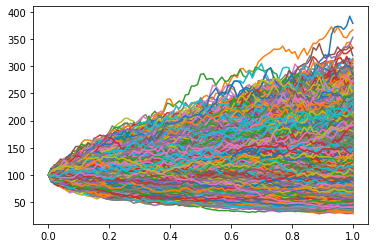

In [7]:
print("Monte Carlo: ", MC_option_price(
    S0 = 100, 
    T2 = 1, 
    n1 = 50, 
    n2 = 100, 
    r = 0.1,
    q = 0,
    sigma = 0.3)
)

## Closed Form

According to [Gray and Whaley, 1999](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.1015.8221&rep=rep1&type=pdf), the closed form of the reset put option price is 
\begin{align*}
    p_0 &= S_0 e^{-qT_1 -r(T_2-T_1)} N(a_1) N(-c_2) - S_0 e^{-qT_2} N(a_1) N(-c_1) \\
    & \qquad + S_0 e^{-rT_2} N_2\left(-b_2, -a_2, \sqrt{\frac{T_1}{T_2}}\right) - S_0 e^{-qT_2} N_2\left(-b_1, -a_1, \sqrt{\frac{T_1}{T_2}}\right),
\end{align*}

where $\begin{aligned}
& a_1 = \dfrac{(r-q+\frac{1}{2}\sigma^2)T_1}{\sigma\sqrt{T_1}}, a_2 = a_1 - \sigma\sqrt{T_1},\\
& b_1 = \dfrac{(r-q+\frac{1}{2}\sigma^2)T_2}{\sigma\sqrt{T_2}}, b_2 = b_1 - \sigma\sqrt{T_2}, \\
& c_1 = \dfrac{(r-q+\frac{1}{2}\sigma^2)(T_2-T_1)}{\sigma\sqrt{T_2-T_1}}, c_2 = c_1 - \sigma\sqrt{T_2-T_1}.
\end{aligned}$

In [8]:
def closed_form_option_price(S0, T1, T2, r, q, sigma):
    a1 = ( (r - q + 0.5 * sigma**2) * T1 ) / (sigma * np.sqrt(T1))
    a2 = ( (r - q - 0.5 * sigma**2) * T1 ) / (sigma * np.sqrt(T1))
    b1 = ( (r - q + 0.5 * sigma**2) * T2 ) / (sigma * np.sqrt(T2))
    b2 = ( (r - q - 0.5 * sigma**2) * T2 ) / (sigma * np.sqrt(T2))
    c1 = ( (r - q + 0.5 * sigma**2) * (T2 - T1) ) / (sigma * np.sqrt(T2 - T1))
    c2 = ( (r - q - 0.5 * sigma**2) * (T2 - T1) ) / (sigma * np.sqrt(T2 - T1))
    
    rho = np.sqrt(T1 / T2)
    Sigma = np.array(
        [[1, rho],
        [rho, 1]]
    )

    return (
        S0 * np.exp(-q * T1 - r * (T2 - T1)) * norm.cdf(a1) * norm.cdf(-c2)
        - S0 * np.exp(-q * T2) * norm.cdf(a1) * norm.cdf(-c1)
        + S0 * np.exp(-r * T2) * mvn.cdf(np.array([-b2, -a2]), mean = np.zeros(2), cov = Sigma)
        - S0 * np.exp(-q * T2) * mvn.cdf(np.array([-b1, -a1]), mean = np.zeros(2), cov = Sigma)
    )

In [9]:
print("Closed Form: ", closed_form_option_price(
    S0 = 100, 
    T1 = 0.5, 
    T2 = 1, 
    r = 0.1, 
    q = 0,
    sigma = 0.3)
)

Closed Form:  9.8201508674406
